# TED Talks Recommendation System using Machine Learning

In this notebook, I'll build a **content-based recommendation system** for TED Talks. It will recommend talks based on user input by analyzing the similarity of talk descriptions using **TF-IDF** and **cosine similarity**.


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string
import warnings
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Load and Explore the Dataset

I’ll use a dataset containing TED Talk information from 2006 to 2020.

In [6]:
# Load dataset
df = pd.read_csv('tedx_dataset.csv')

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Shape of the dataset
print(f"\nDataset Shape: {df.shape}")

# Check for missing values
print(f"\nMissing values per column:\n{df.isnull().sum()}")

First 5 rows of the dataset:
                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2

### Extract Year and Month from 'posted'

I'll extract the year and month to analyze trends over time.

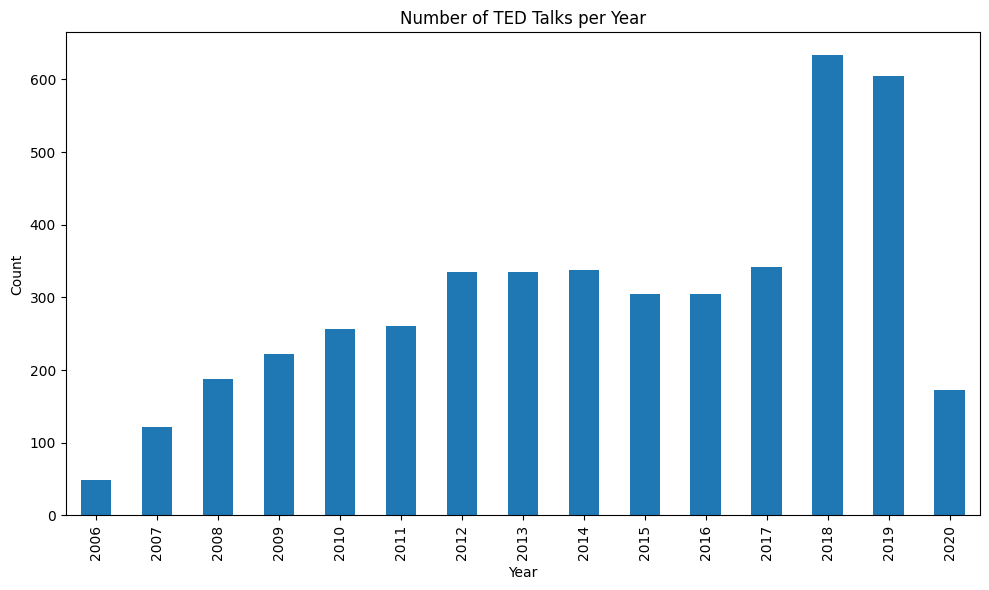

In [7]:
# Extract year and month from 'posted' column
if 'posted' in df.columns:
    splitted = df['posted'].str.split(' ', expand=True)
    df['year'] = splitted[2].astype(int)
    df['month'] = splitted[1]

    # Plot number of talks per year
    plt.figure(figsize=(10, 6))
    df['year'].value_counts().sort_index().plot(kind='bar')
    plt.title('Number of TED Talks per Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### Combine Title and Details

I'll merge the `title` and `details` columns to use full context for recommendations.

In [8]:
# Combine title and details
df['details'] = df['title'] + ' ' + df['details']

# Keep only relevant columns
df = df[['main_speaker', 'details']]
df.dropna(inplace=True)

# Save clean copy
data = df.copy().reset_index(drop=True)

# Show sample
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


## 2. Text Preprocessing

I clean the text by:
- Removing stopwords (e.g., "the", "and")
- Removing punctuation
- Converting to lowercase

In [9]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = str(text).lower().split()
    return ' '.join([word for word in words if word not in stop_words])

df['details'] = df['details'].apply(remove_stopwords)
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


In [10]:
# Remove punctuation
punctuations = string.punctuation

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)

df['details'] = df['details'].apply(remove_punctuations)
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


## 3. Word Cloud: Most Frequent Words
Let's visualize the most common words in TED Talk descriptions.

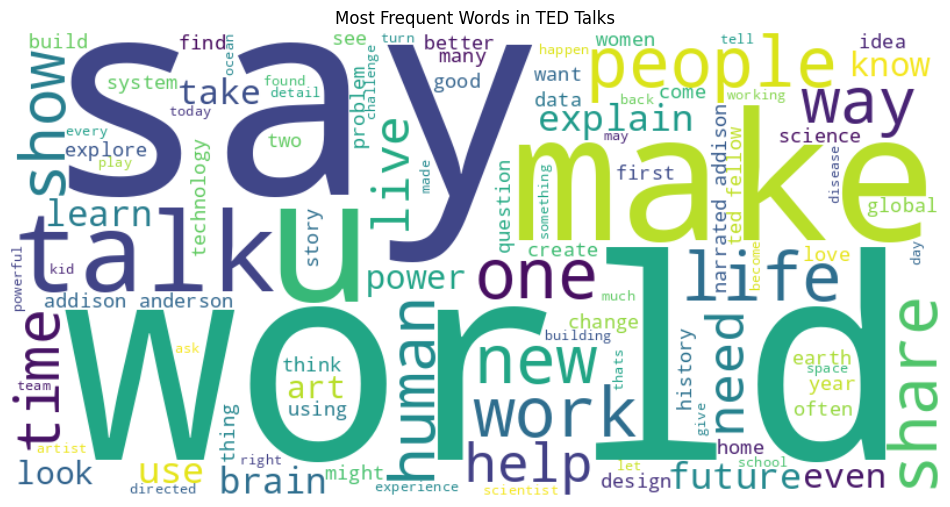

In [11]:
# Generate word cloud
corpus = " ".join(df['details'])
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in TED Talks')
plt.show()

## 4. Build the Recommendation System

I’ll use:
- **TF-IDF Vectorizer** to convert text to numbers
- **Cosine Similarity** and **Pearson Correlation** to measure similarity

In [12]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(analyzer='word')
vectorizer.fit(df['details'])

# Function to compute similarities
def get_similarities(talk_content, data=df):
    talk_array1 = vectorizer.transform(talk_content).toarray()
    cos_similarities = []
    pearson_similarities = []

    for idx, row in data.iterrows():
        talk_array2 = vectorizer.transform([row['details']]).toarray()
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
        pearson_sim = pearsonr(talk_array1.flatten(), talk_array2.flatten())[0]
        
        cos_similarities.append(cos_sim)
        pearson_similarities.append(pearson_sim)
    
    return cos_similarities, pearson_similarities

# Recommendation function
def recommend_talks(talk_content, data=data):
    data = data.copy()
    cos_sim, pea_sim = get_similarities(talk_content, data)
    
    data['cos_sim'] = cos_sim
    data['pea_sim'] = pea_sim
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False, False], inplace=True)
    
    print("\nTop 5 Recommended TED Talks:")
    print(data[['main_speaker', 'details']].head().to_string(index=False))

## 5. Test the Recommender System

Let’s try out the system with sample queries!

In [13]:
print("="*60)
print("RECOMMENDATIONS FOR: 'Time management and working hard to become successful in life'")
print("="*60)
recommend_talks(['Time management and working hard to become successful in life'])

RECOMMENDATIONS FOR: 'Time management and working hard to become successful in life'

Top 5 Recommended TED Talks:
       main_speaker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              details
         John Doerr                                                                                                                                                                                         